# WattsNext: Universal Energy Forecasting (XGBoost + LSTM)

In [1]:
# Install dependencies
!pip install xgboost tensorflow --quiet


In [2]:
# Upload your CSV dataset here
import pandas as pd
from google.colab import files

file_name = "/content/energy_dataset.csv"

df = pd.read_csv(file_name)
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Auto-clean dataset
import numpy as np

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")
df = df.dropna(axis=1, how='all')
df = df.loc[:, (df != df.iloc[0]).any()]
df = df.loc[:, (df != 0).mean() > 0.05]
time_col = next((col for col in df.columns if 'time' in col or 'date' in col), None)
if time_col:
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    df = df.set_index(time_col).sort_index()
df = df.dropna()
df.head()


/tmp/ipython-input-3684630766.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
# Select target column
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
target = "total_load_actual" if "total_load_actual" in numeric_cols else numeric_cols[0]
print("Selected target:", target)


Selected target: total_load_actual


Model failed to train or got interrupted
🔶 XGBoost Results:
RMSE: 409.44390562849526
MAE: 296.63450070941605
R²: 0.9917898355641352


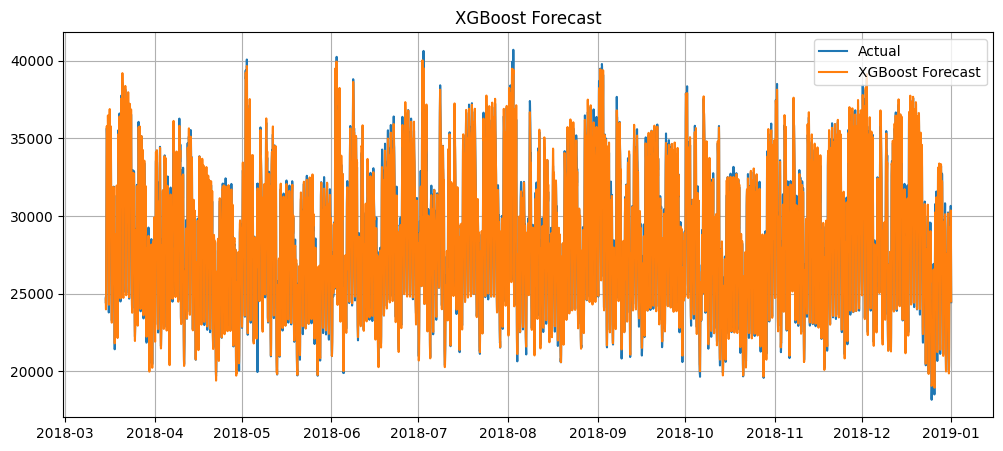

None


In [6]:
# XGBoost Forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=[target])
y = df[target]
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)
if 'y_pred' in locals():
  print("y_pred is defined")
else:
  print("Model failed to train or got interrupted")
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("🔶 XGBoost Results:")
print("RMSE:", rmse)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="XGBoost Forecast")
plt.legend(); plt.grid(); plt.title("XGBoost Forecast")
print(plt.show())



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 100993184.0000
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 14275077.0000
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 4374853.0000
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 2858142.0000
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 3238371.7500
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 2060481.8750
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - loss: 1799779.3750
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1254111.7500
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1009131.8125
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 950248.8750
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 968825.8125
Epoch 12/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 916830.7500
Epoch 13/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 859834.3750
Epoch 1

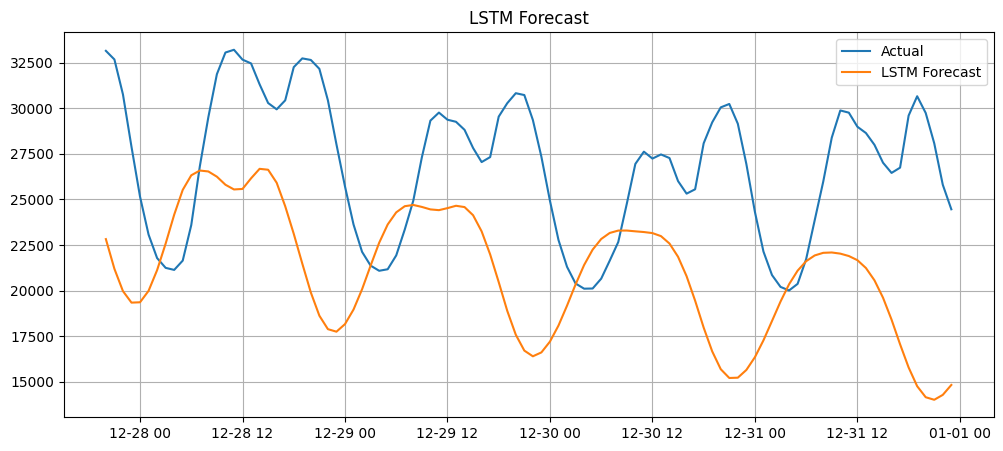

In [7]:
# LSTM Forecasting
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

seq_length = 24
data_seq = df[[target]].values
ts_gen = TimeseriesGenerator(data_seq, data_seq, length=seq_length, batch_size=32)

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(ts_gen, epochs=20, verbose=1)

lstm_preds = []
input_seq = data_seq[-seq_length:].reshape(1, seq_length, 1)
for _ in range(min(100, len(df))):
    next_val = lstm_model.predict(input_seq, verbose=0)[0][0]
    lstm_preds.append(next_val)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_val]]], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(df.index[-len(lstm_preds):], df[target].values[-len(lstm_preds):], label="Actual")
plt.plot(df.index[-len(lstm_preds):], lstm_preds, label="LSTM Forecast")
plt.legend(); plt.grid(); plt.title("LSTM Forecast")
plt.show()


In [8]:
#Evaluation metrics
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
smape = smape(y_test, y_pred)

print("MAPE:", mape)
print("SMAPE:", smape)

MAPE: 1.027308150645373
SMAPE: 1.0263879006212515


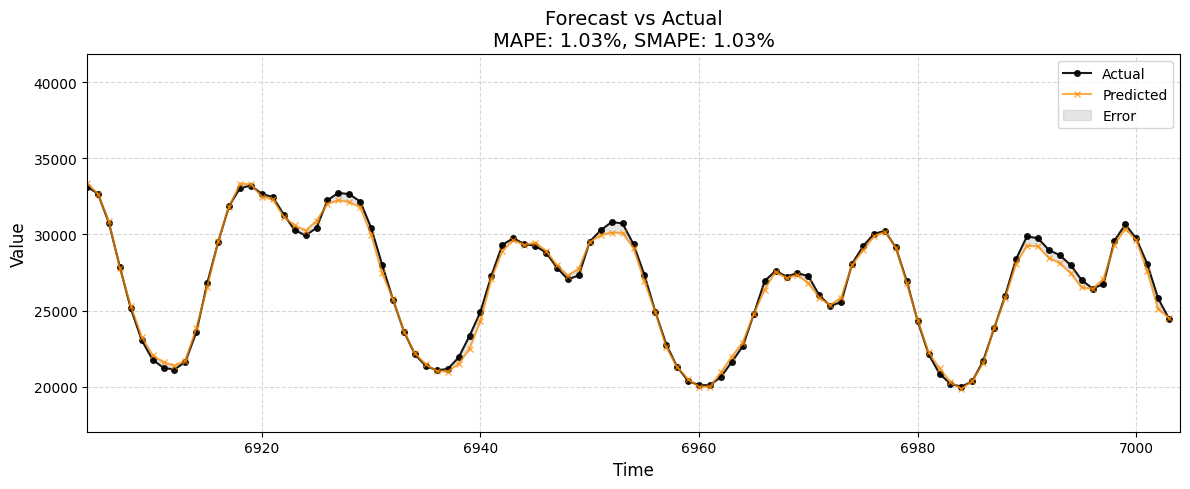

In [9]:
#statistical plots
x = np.arange(len(y_test))

plt.figure(figsize=(12, 5))

# Use thinner lines, distinct colors, and partial transparency
plt.plot(x, y_test, marker='o', markersize=4, linewidth=1.5, label='Actual', color='black', alpha=0.9)
plt.plot(x, y_pred, marker='x', markersize=4, linewidth=1.5, label='Predicted', color='darkorange', alpha=0.7)

# Light error shading
plt.fill_between(x, y_test, y_pred, color='gray', alpha=0.2, label='Error')

# Plot only a slice if it’s too dense
if len(x) > 150:
    plt.xlim(len(x)-100, len(x))  # show only last 100 points

plt.title(f"Forecast vs Actual\nMAPE: {mape:.2f}%, SMAPE: {smape:.2f}%", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

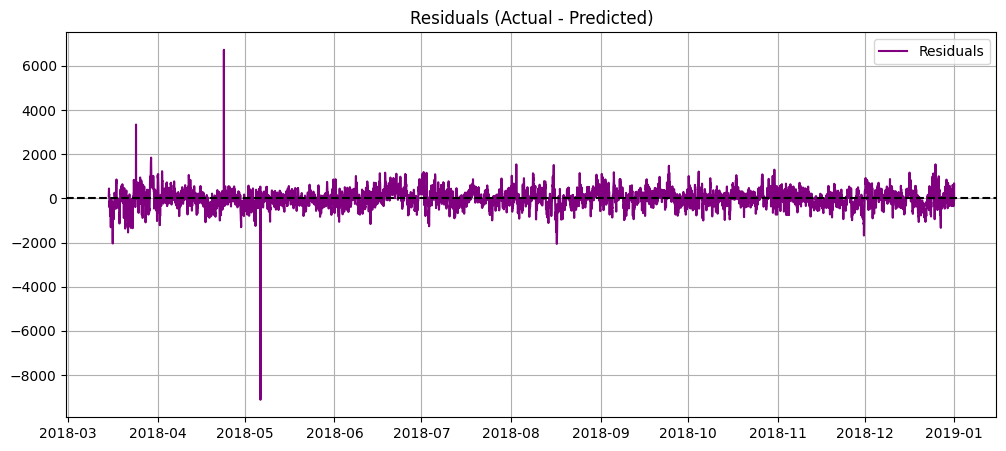

In [10]:
#plotting residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, residuals, label="Residuals", color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.legend(); plt.grid(); plt.title("Residuals (Actual - Predicted)")
plt.show()

In [11]:
#interactive graph
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='black')))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred, mode='lines', name='XGBoost', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=y_test.index[-len(lstm_preds):], y=lstm_preds, mode='lines', name='LSTM', line=dict(dash='dot')))

fig.update_layout(title='Forecast Comparison',
                  xaxis_title='Time',
                  yaxis_title='Value',
                  template='plotly_white')
fig.show()

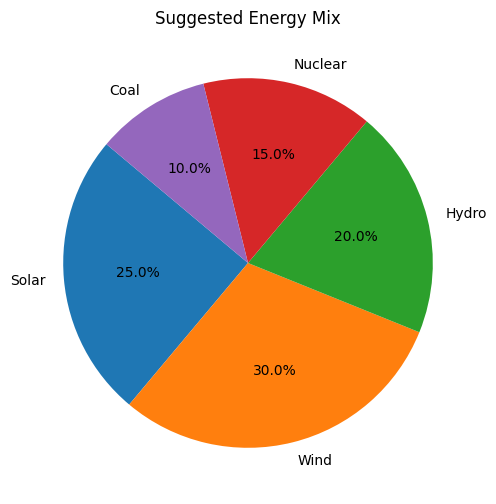

In [12]:
labels = ['Solar', 'Wind', 'Hydro', 'Nuclear', 'Coal']
values = [25, 30, 20, 15, 10]  # adjust based on dataset or prediction logic

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Suggested Energy Mix")
plt.show()